# Sparkify Project

### Step 1: Setup

#### Import Libraries

In [1]:
import pyspark
from functools import reduce
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window, DataFrame
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import (sum as Fsum, min as Fmin, max as Fmax,
                                   col, when, isnull, mean,
                                   count, desc, asc, regexp_replace,
                                   udf, trim, lower, avg)
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import (OneHotEncoder,
                                StringIndexer, VectorAssembler,
                                MinMaxScaler)
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from matplotlib.colors import ListedColormap
from typing import Iterable

#### Start a Spark Session

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Step 2: Load and Clean Dataset

Uncomment the desired path below. The mini dataset is provided in the repo. The larger dataset can be loaded from an AWS S3 bucket.

In [3]:
%%time
path = "mini_sparkify_event_data.json"
#path = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
user_log = spark.read.json(path)

CPU times: user 0 ns, sys: 5.25 ms, total: 5.25 ms
Wall time: 10.6 s


The following cells remove missing values and other formatting issues discovered in the data.

In [4]:
# Check for missing values. Also checks for blank strings
user_log.select([count(when(col(c) == "", c).when(isnull(c), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,8346


In [5]:
# Check the size of the dataset
user_log.toPandas().shape

(286500, 18)

In [6]:
# There are missing values in userid and sessionid, so need to drop.
# Blank userIds are disguised as empty strings
user_log = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log = user_log.filter(user_log.userId != '')

In [7]:
# Gut check to see what null values are left, and whether the
# previous step worked
user_log.select([count(when(col(c) == "", c).when(isnull(c), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


In [8]:
# Adjust the timestamp format from miliseconds to seconds for
# convenience
user_log = user_log.withColumn('ts', col('ts')/1000)
user_log = user_log.withColumn('registration', col('registration')/1000)

In [9]:
# Check the distribution of auth against our target variable (cancellations)
user_log.select(['auth', 'page']).groupBy(['auth', 'page']).agg(count('page')).show()

+---------+--------------------+-----------+
|     auth|                page|count(page)|
+---------+--------------------+-----------+
|Logged In|              Logout|       3226|
|Logged In|           Thumbs Up|      12551|
|Logged In|         Roll Advert|       3933|
|Logged In|      Submit Upgrade|        159|
|Logged In|            Settings|       1514|
|Logged In|         Thumbs Down|       2546|
|Logged In|       Save Settings|        310|
|Logged In|                Help|       1454|
|Logged In|            NextSong|     228108|
|Logged In|               About|        495|
|Logged In|     Add to Playlist|       6526|
|Logged In|               Error|        252|
|Logged In|                Home|      10082|
|Cancelled|Cancellation Conf...|         52|
|Logged In|          Add Friend|       4277|
|Logged In|           Downgrade|       2055|
|Logged In|             Upgrade|        499|
|Logged In|              Cancel|         52|
|Logged In|    Submit Downgrade|         63|
+---------

In [10]:
# These columns are dropped because they are uhnlikely to provide
# much value. For example, firstname/lastname shouldn't have
# much to do with users deciding to cancel, and auth is perfectly
# correlated with our target variable, so we don't want to include it
user_log = user_log.drop("auth", "firstName", "lastName")

In [11]:
# artist and userAgent have a lot of unique values. The following lines
# try to reduce the number of characters for each.

# Filter rows with regex (find rows that match expression)
user_log = user_log.withColumn('artist', regexp_replace('artist', r'[^0-9a-zA-Z]', ' '))
user_log = user_log.withColumn('userAgent', regexp_replace('userAgent', r'[^a-zA-Z]', ' '))
user_log = user_log.withColumn('userAgent', trim(lower(regexp_replace('userAgent', r'\s+', ' '))))
user_log = user_log.withColumn('userAgent', regexp_replace('userAgent', r'\s[a-z]\s', ' '))

In [12]:
# Keep a copy of the original column list for convenience
original_col_list = list(user_log.columns)

For the categorical columns, it is likely to be helpful to have one-hot encoded columns. To do this in spark, you need to create a string index for each column, and then use that index to instantiate the OneHotEncoder class for each indexed column. 

In [13]:
## One hot encode column variables

# Create string index for each column to be encoded
onehot_cols = ['gender', 'level', 'method', 'userAgent', 'page', 'status']
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_indexed")
    for column in onehot_cols
]

# Use the index column to prepare the one-hot encoder
encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol=indexer.getOutputCol()+"_encoded",
        dropLast=False
    ) 
    for indexer in indexers
]

# Generate a vector of encoded values using VectorAssembler for
# each row
assembler = [VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="onehot_features"
)]

# Run the string index, encoder, and assembler as a Pipeline,
# save the output back to the spark dataframe
onehot_pipeline = Pipeline(stages=indexers + encoders + assembler)
onehot_pipeline = onehot_pipeline.fit(user_log)
user_log = onehot_pipeline.transform(user_log)

# Generate the list of column names for convenience later (using
# VectorAssembler, the column names are not saved to the dataframe
# and need to be recovered)
#
# userAgent is renamed here because each value is a really long string
# and this makes the column name more convenient
expanded_oh_names = []
for i, column in enumerate(onehot_cols):
    for j, label in enumerate(onehot_pipeline.stages[i].labels):
        if column == 'userAgent':
            expanded_oh_names.append(column + '_' + str(j))
        else:
            expanded_oh_names.append(column + '_' + label)

# Generate list of columns to keep in the dataframe. For most purposes,
# this would be a list of the columns that were not encoded.
# If any of the columns in the list are one-hot encoded, this list
# will keep the original, non-encoded column in the dataframe
no_hot_cols = [c for c in original_col_list if c not in onehot_cols]
#no_hot_cols = ["artist", "gender", "itemInSession", "length",
#    "level", "location", "method", "page", "registration", "sessionId",
#    "song", "ts", "userAgent", "userId"]


# create a new, expanded column list.
all_cols = no_hot_cols + expanded_oh_names

def extract(row, column_list):
    '''
    For each row, extract the one-hot values in the row vector (from
    VectorAssembler), along with any columns listed in column_list.
    
    Returns a tuple of values.
    '''
    col_tup = tuple(row[column] for column in column_list)
    return col_tup + tuple(row.onehot_features.toArray().tolist())

user_log = user_log.rdd.map(partial(extract, column_list=no_hot_cols)).toDF(all_cols)

### Step 3: Define Churn and Explore

Below are some helpful functions I could have used to define churn. This isn't necessary since the variable is one-hot encoded for us in the previous step. Instead, I just rename an equivalent column.

In [14]:
## function to flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
## flag event
#user_log = user_log.withColumn("cancelled", flag_downgrade_event("page"))

## Window 
#windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
#user_log_valid = user_log.withColumn("phase", Fsum("cancelled").over(windowval))

In [15]:
user_log = user_log.withColumnRenamed('page_Cancellation Confirmation', 'cancelled')

Next, the data is prepped for some exploration and plotting.

In [16]:
# Convert to pandas for easy plotting/exploring
id_group = user_log.groupBy(["userId", "sessionId"]) \
                    .agg(
                        Fmax('itemInSession').alias('num_items_in_session'),
                        Fmax('length').alias('longest_song_in_session'),
                        Fsum('length').alias('session_listening_time'),
                        count('song').alias('number_of_songs'),
                        Fmin('ts').alias('session_begin'),
                        Fmax('ts').alias('session_end'),
                        (Fmax('ts')-Fmin('ts')).alias('session_length'),
                        Fmax('gender_F').alias('gender_F'),
                        Fsum('page_Error').alias('num_errors'),
                        Fsum('level_paid').alias('num_paid_interactions'),
                        Fmax('cancelled').alias('cancelled')
                    ) \
                    .groupBy('userId') \
                    .agg(
                        when(count('sessionId') <= 1, 0)
                        .otherwise(((Fmax('session_end')-Fmin('session_begin'))
                                    -Fsum('session_length'))/(count('sessionId')-1))
                        .alias('avg_time_between_sessions'),
                        avg('session_length').alias('avg_session_length'),
                        avg('gender_F').alias('avg_gender_F'),
                        (Fsum('session_listening_time')/count('sessionId')).alias('listening_time_per_session'),
                        count('sessionId').alias('total_number_of_sessions'),
                        avg('num_errors').alias('avg_num_errors'),
                        avg('num_paid_interactions').alias('avg_num_paid_interactions'),
                        Fmax('cancelled').alias('cancelled')
                    ).toPandas()

In [17]:
def group_differences(data, target_val, group_vals):
    '''
    Groups the target variable by a grouping variable, and returns the mean values
    and error for each group. 
    
    data: dataframe
        The dataframe of data
    target_val : str
        The target column of the dataset
    group_val : str or list
        The column to create the groups for comparison
    '''
    from scipy.stats import t
    ci_stand_error = lambda x: (x.std(ddof=1)/(np.sqrt(x.shape[0])))*t.ppf(0.975, df=x.shape[0])
    
    if isinstance(target_val, str):
        target_val = [target_val]
        
    concats = []
    for tv in target_val:
        new_group = data.groupby(group_vals, as_index=True).agg(
                          {tv: ['mean', ci_stand_error]})
        new_group.columns.set_levels([[tv], ['Mean', 'Error']],
                                  level=None, inplace=True)
        concats.append(new_group)

    grouped_df = pd.concat(concats, axis=1)
    return grouped_df

([<matplotlib.axis.XTick at 0x7f6e98513d68>,
 <a list of 2 Text xticklabel objects>)

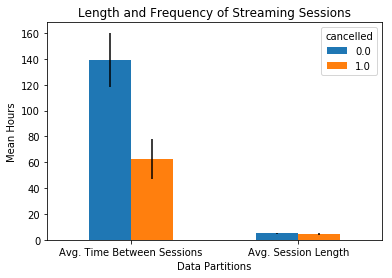

In [18]:
sess_info = group_differences(id_group, target_val=['avg_time_between_sessions', 'avg_session_length'],
                              group_vals=['cancelled'])/3600

err_vals = sess_info.T.xs('Error', level=1, drop_level=False).T.values
sess_info.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Length and Frequency of Streaming Sessions',
                                                           #xlabel='Data Partitions',
                                                           #ylabel='Mean'
                                                          )
plt.xlabel('Data Partitions')
plt.ylabel('Mean Hours')
plt.xticks([0, 1], ['Avg. Time Between Sessions', 'Avg. Session Length'], rotation=0,
          ha='center')

In [19]:
sess_info = group_differences(id_group, target_val=['avg_time_between_sessions', 'avg_num_paid_interactions'],
                              group_vals=['cancelled'])/3600

sess_info

avg_time_between_sessions            avg_num_paid_interactions  \
                               Mean      Error                      Mean   
cancelled                                                                  
0.0                      139.294639  21.017770                  0.018203   
1.0                       62.594419  15.521846                  0.014672   

                     
              Error  
cancelled            
0.0        0.002450  
1.0        0.004494

([<matplotlib.axis.XTick at 0x7f6e5a0c2518>],
 <a list of 1 Text xticklabel objects>)

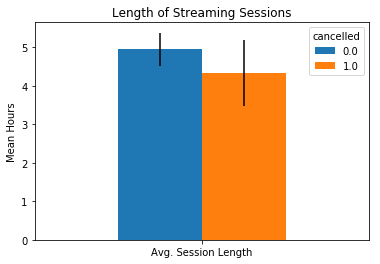

In [20]:
sess_info = group_differences(id_group, target_val=['avg_session_length'],
                              group_vals=['cancelled'])/3600

err_vals = sess_info.T.xs('Error', level=1, drop_level=False).T.values
sess_info.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Length of Streaming Sessions',
                                                           #xlabel='Data Partitions',
                                                           #ylabel='Mean'
                                                          )
#plt.xlabel('Data Partitions')
plt.ylabel('Mean Hours')
plt.xticks([0], ['Avg. Session Length'], rotation=0,
          ha='center')

([<matplotlib.axis.XTick at 0x7f6e59250240>],
 <a list of 1 Text xticklabel objects>)

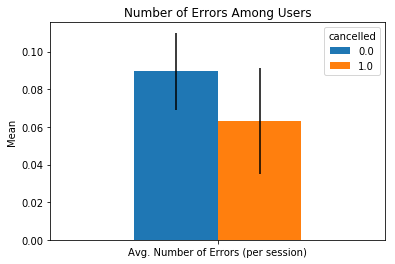

In [21]:
sess_info = group_differences(id_group, target_val=['avg_num_errors'],
                              group_vals=['cancelled'])

err_vals = sess_info.T.xs('Error', level=1, drop_level=False).T.values
sess_info.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Number of Errors Among Users',
                                                           #xlabel='Data Partitions',
                                                           #ylabel='Mean'
                                                          )
#plt.xlabel('Data Partitions')
plt.ylabel('Mean')
plt.xticks([0], ['Avg. Number of Errors (per session)'], rotation=0,
          ha='center')

In [22]:
#group_differences(id_group, target_val='avg_time_between_sessions', group_vals=['avg_gender_F', 'cancelled'])

In [23]:
group_differences(id_group, target_val='total_number_of_sessions', group_vals=['cancelled'])

total_number_of_sessions          
                              Mean     Error
cancelled                                   
0.0                      15.254335  2.381045
1.0                      10.326923  2.396144

([<matplotlib.axis.XTick at 0x7f6e584dfef0>],
 <a list of 1 Text xticklabel objects>)

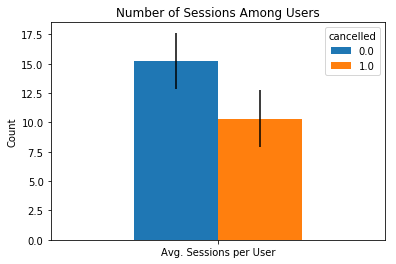

In [24]:
sess_info = group_differences(id_group, target_val='total_number_of_sessions',
                              group_vals=['cancelled'])

err_vals = sess_info.T.xs('Error', level=1, drop_level=False).T.values
sess_info.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Number of Sessions Among Users',
                                                           #xlabel='Data Partitions',
                                                           #ylabel='Mean'
                                                          )
#plt.xlabel('Data Partitions')
plt.ylabel('Count')
plt.xticks([0], ['Avg. Sessions per User'], rotation=0,
          ha='center')

Text(0,0.5,'Average Time Between Sessions (hours)')

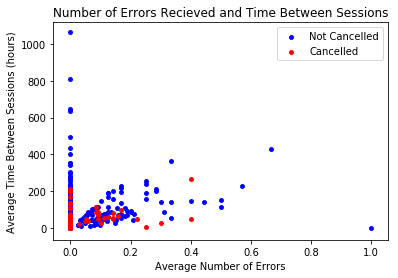

In [25]:
fig, ax = plt.subplots()
for color in ['blue', 'red']:
    if color == 'red':
        X = id_group[id_group['cancelled'] == 1]['avg_num_errors'].values
        Y = id_group[id_group['cancelled'] == 1]['avg_time_between_sessions'].values/3600
    else:
        X = id_group[id_group['cancelled'] == 0]['avg_num_errors'].values
        Y = id_group[id_group['cancelled'] == 0]['avg_time_between_sessions'].values/3600
    
    ax.scatter(X, Y, c=color, label=color,
               s=15)

ax.legend(labels=['Not Cancelled', 'Cancelled'])
plt.title('Number of Errors Recieved and Time Between Sessions')
plt.xlabel('Average Number of Errors')
plt.ylabel('Average Time Between Sessions (hours)')

Text(0,0.5,'Average number of Paid Sessions')

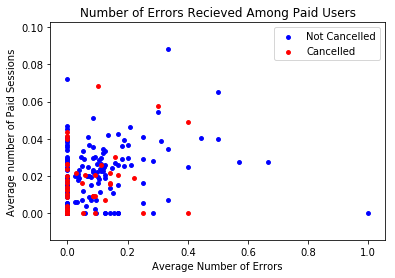

In [26]:
fig, ax = plt.subplots()
for color in ['blue', 'red']:
    if color == 'red':
        X = id_group[id_group['cancelled'] == 1]['avg_num_errors'].values
        Y = id_group[id_group['cancelled'] == 1]['avg_num_paid_interactions'].values/3600
    else:
        X = id_group[id_group['cancelled'] == 0]['avg_num_errors'].values
        Y = id_group[id_group['cancelled'] == 0]['avg_num_paid_interactions'].values/3600
    
    ax.scatter(X, Y, c=color, label=color,
               s=15)

ax.legend(labels=['Not Cancelled', 'Cancelled'])
plt.title('Number of Errors Recieved Among Paid Users')
plt.xlabel('Average Number of Errors')
plt.ylabel('Average number of Paid Sessions')

Text(0,0.5,'Average Time Between Sessions (hours)')

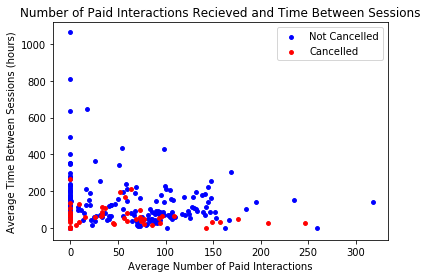

In [27]:
fig, ax = plt.subplots()
for color in ['blue', 'red']:
    if color == 'red':
        X = id_group[id_group['cancelled'] == 1]['avg_num_paid_interactions'].values
        Y = id_group[id_group['cancelled'] == 1]['avg_time_between_sessions'].values/3600
    else:
        X = id_group[id_group['cancelled'] == 0]['avg_num_paid_interactions'].values
        Y = id_group[id_group['cancelled'] == 0]['avg_time_between_sessions'].values/3600
    
    ax.scatter(X, Y, c=color, label=color,
               s=15)

ax.legend(labels=['Not Cancelled', 'Cancelled'])
plt.title('Number of Paid Interactions Recieved and Time Between Sessions')
plt.xlabel('Average Number of Paid Interactions')
plt.ylabel('Average Time Between Sessions (hours)')

### Step 4: Feature Engineering

The data is consolidated to a one-row-per-user format by using two consecutive groupby functions. The first groupby condenses the session data for each user, so each user has summary statistics for each session they had. Then, each session is grouped together so that each user has summary statistics about their total session history. The data was grouped using Spark SQL functionality. The full query is shown in the `SqlFeatureEngineer` class.

In [28]:
# generate the arbitrary list of userAgent column names for passing
# to the SqlFeatureEngineer class
agents = [name for name in expanded_oh_names if "userAgent" in name]

In [29]:
class SqlFeatureEngineer(Transformer):
    """
    Custom Transform to feature engineer using a SQL query
    """

    def __init__(self, table_name: str, agents: Iterable[str]):
        super(SqlFeatureEngineer, self).__init__()
        self.table_name = table_name
        
        sum_UA = "".join("\n        ,SUM(%s) as num_%s_interactions" % (agent, agent) for agent in agents)
        avg_UA = "".join("\n    ,AVG(sess.num_%s_interactions) as avg_%s_interactions" % (agent, agent) for agent in agents)

        session_query_select = """SELECT 
            sess.userId
            ,AVG(sess.num_items_in_session) as avg_num_items_in_session
            ,MAX(sess.longest_song_in_session) as longest_song
            ,AVG(sess.longest_song_in_session) as longest_song_per_session
            ,COUNT(sess.sessionId) as total_number_of_sessions
            ,SUM(sess.session_listening_time)/COUNT(sess.sessionId) as listening_time_per_session
            ,SUM(sess.number_of_songs)/COUNT(sess.sessionId) as avg_number_of_songs_per_session
            ,SUM(sess.session_listening_time)/SUM(sess.number_of_songs) as avg_song_length
            ,AVG(sess.session_length) as avg_session_length
            ,MAX(sess.session_end)-MIN(sess.registration) as time_since_joined
            ,MIN(sess.session_begin)-MIN(sess.registration) as time_to_first_session 
            ,CASE
                WHEN COUNT(sess.sessionId) <= 1 THEN 0
                ELSE ((MAX(sess.session_end)-MIN(sess.session_begin)) - SUM(sess.session_length))/(COUNT(sess.sessionId)-1)
            END as avg_time_between_sessions
            ,AVG(sess.gender_F) as avg_gender_F
            ,AVG(sess.gender_M) as avg_gender_M
            ,AVG(sess.status_200) as avg_status_200
            ,AVG(sess.status_307) as avg_status_307
            ,AVG(sess.status_404) as avg_status_404
            ,AVG(sess.num_paid_interactions) as avg_num_paid_interactions
            ,AVG(sess.num_free_interactions) as avg_num_free_interactions
            ,AVG(sess.num_put_interactions) as avg_num_put_interactions
            ,AVG(sess.num_get_interactions) as avg_num_get_interactions
            ,AVG(sess.num_nextsong_clicks) as avg_num_nextsong_clicks
            ,AVG(sess.num_thumbsup_clicks) as avg_num_thumbsup_clicks
            ,AVG(sess.num_home_visits) as avg_num_home_visits
            ,AVG(sess.num_addtoplaylist_clicks) as avg_num_addtoplaylist_clicks
            ,AVG(sess.num_addfriend_clicks) as avg_num_addfriend_clicks
            ,AVG(sess.num_rolladvert_visits) as avg_num_rolladvert_visits
            ,AVG(sess.num_logout_visits) as avg_num_logout_visits
            ,AVG(sess.num_thumbsdown_clicks) as avg_num_thumbsdown_clicks
            ,AVG(sess.num_downgrade_visits) as avg_num_downgrade_visits
            ,AVG(sess.num_settings_visits) as avg_num_settings_visits
            ,AVG(sess.num_help_visits) as avg_num_help_visits
            ,AVG(sess.num_upgrade_visits) as avg_num_upgrade_visits
            ,AVG(sess.num_about_visits) as avg_num_about_visits
            ,AVG(sess.num_savesettings_clicks) as avg_num_savesettings_clicks
            ,AVG(sess.num_errors) as avg_num_errors
            ,AVG(sess.num_upgrades) as avg_num_upgrades
            ,AVG(sess.num_downgrades) as avg_num_downgrades
            --,AVG(sess.num_cancel_visits) as avg_num_cancel_visits
            ,MAX(sess.cancelled) as cancelled"""

        session_query_from = """
        FROM (
            SELECT 
                userId
                ,sessionId
                ,MAX(itemInSession) as num_items_in_session
                ,MAX(length) as longest_song_in_session
                ,SUM(length) as session_listening_time
                ,COUNT(song) as number_of_songs
                ,min(ts) as session_begin
                ,max(ts) as session_end
                ,max(ts) - min(ts) as session_length
                ,MIN(registration) as registration
                ,MAX(cancelled) as cancelled
                ,MAX(gender_F) as gender_F
                ,MAX(gender_M) as gender_M
                ,SUM(status_200) as status_200
                ,SUM(status_307) as status_307
                ,SUM(status_404) as status_404
                ,SUM(level_paid) as num_paid_interactions
                ,SUM(level_free) as num_free_interactions
                ,SUM(method_PUT) as num_put_interactions
                ,SUM(method_GET) as num_get_interactions
                ,SUM(page_NextSong) as num_nextsong_clicks
                ,SUM(`page_Thumbs Up`) as num_thumbsup_clicks
                ,SUM(page_Home) as num_home_visits
                ,SUM(`page_Add to Playlist`) as num_addtoplaylist_clicks
                ,SUM(`page_Add Friend`) as num_addfriend_clicks
                ,SUM(`page_Roll Advert`) as num_rolladvert_visits
                ,SUM(page_Logout) as num_logout_visits
                ,SUM(`page_Thumbs Down`) as num_thumbsdown_clicks
                ,SUM(page_Downgrade) as num_downgrade_visits
                ,SUM(page_Settings) as num_settings_visits
                ,SUM(page_Help) as num_help_visits
                ,SUM(page_Upgrade) as num_upgrade_visits
                ,SUM(page_About) as num_about_visits
                ,SUM(`page_Save Settings`) as num_savesettings_clicks
                ,SUM(page_Error) as num_errors
                ,SUM(`page_Submit Upgrade`) as num_upgrades
                ,SUM(`page_Submit Downgrade`) as num_downgrades
                ,SUM(page_Cancel) as num_cancel_visits""" 

        session_query = session_query_select + avg_UA + session_query_from + sum_UA + """
            FROM """ + self.table_name + """
            GROUP BY
                userId,
                sessionId
        ) as sess
        GROUP BY
            userId
        """
        
        self.query = session_query

    def _transform(self, df: DataFrame) -> DataFrame:
        df.createOrReplaceTempView(self.table_name)
        summary = spark.sql(self.query)
        return summary

In [30]:
%%time
table_name = 'user_log_temp'
user_summary = SqlFeatureEngineer(table_name, agents).transform(user_log)

CPU times: user 2.01 ms, sys: 194 µs, total: 2.2 ms
Wall time: 1.1 s


CPU times: user 542 ms, sys: 48.4 ms, total: 590 ms
Wall time: 2min 30s


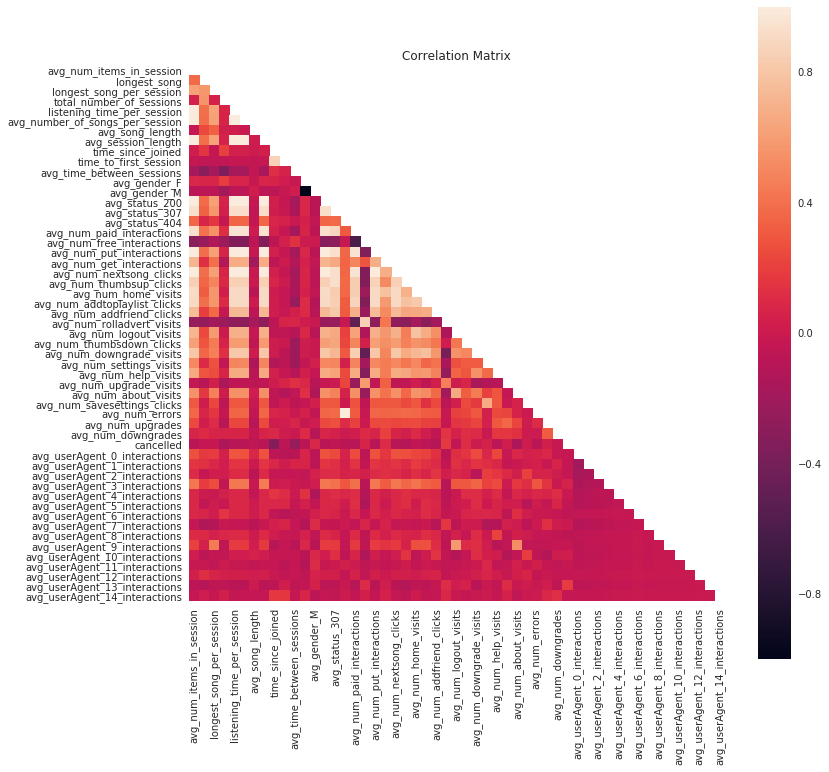

In [31]:
%%time
# Create correlation plot for numerical variables
corr = user_summary.toPandas().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(12, 12)})
with sns.axes_style("white"):
    sns.heatmap(corr, annot=False, square=True, mask=mask)
    plt.title("Correlation Matrix")

In [32]:
%%time
# create a list of columns to min-max scale. Make sure to exclude
# the userId column and the target variable
columns_to_scale = [column for column in user_summary.columns if column != 'userId' and column != 'cancelled']

# min-max scaler
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
transformed = assembler.transform(user_summary)
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel =  scaler.fit(transformed.select("features"))
user_scaled = scalerModel.transform(transformed)

CPU times: user 101 ms, sys: 19.9 ms, total: 121 ms
Wall time: 2min 12s


### Step 5: Modeling

Modeling is performed by first separating the data into a training set and a test set. The training set is then modeled using a cross-validated grid search over a logistic regression model. The userId variable is dropped from the data before modeling. The min-maxed features are used in the model instead of the variables at their original scale. The best model is selected based on the highest F1 score. 

Once the best-fit model has been selected, the model is trained on the entire training set and a final evaluation is performed. 

In [33]:
# drop userId
user_scaled = user_scaled.drop('userId')

In [34]:
# Split into training and test data
(trainingData, testData) = user_scaled.randomSplit([0.8, 0.2], seed=42)

In [35]:
# Check base rate
trainingData.select(mean(trainingData.cancelled)).show()
testData.select(mean(testData.cancelled)).show()

+------------------+
|    avg(cancelled)|
+------------------+
|0.2198952879581152|
+------------------+

+-------------------+
|     avg(cancelled)|
+-------------------+
|0.29411764705882354|
+-------------------+



In [36]:
%%time
# Grid Search
logreg = LogisticRegression(labelCol="cancelled", featuresCol="scaledFeatures",
                            maxIter=100, regParam=0.01, elasticNetParam=0.5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="cancelled", predictionCol="prediction",
    metricName="f1")

pipeline_lr = Pipeline(stages=[logreg])

paramGrid_lr = ParamGridBuilder() \
                .addGrid(logreg.elasticNetParam, [0]) \
                .addGrid(logreg.regParam, [0.01, 0.1]) \
                .build()
    
crossval_lr = CrossValidator(estimator=logreg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator,
                             #numFolds=4)
                             numFolds=2)

CPU times: user 5.88 ms, sys: 553 µs, total: 6.44 ms
Wall time: 77.5 ms


In [37]:
%%time
cvLRModel = crossval_lr.fit(trainingData)

CPU times: user 12.9 s, sys: 4.1 s, total: 17 s
Wall time: 25min 32s


In [38]:
bestLRModel = cvLRModel.bestModel

In [39]:
%%time
predictions_lr = bestLRModel.transform(testData)

CPU times: user 17.8 ms, sys: 2.15 ms, total: 20 ms
Wall time: 191 ms


In [40]:
%%time

f1_lr = evaluator.evaluate(predictions_lr)

acc_lr = evaluator.setMetricName("accuracy").evaluate(predictions_lr)

print("LogReg Test Error = %g -- F1: %g" % (1.0 - acc_lr, f1_lr))

LogReg Test Error = 0.264706 -- F1: 0.647903
CPU times: user 488 ms, sys: 128 ms, total: 616 ms
Wall time: 4min 41s


In [41]:
list(bestLRModel.coefficients)

[-0.20219609477271658,
 0.48260891987364679,
 0.064521926117209041,
 -1.625301029343746,
 -0.37245241444579952,
 -0.35062618721777189,
 -0.35528831783758186,
 -0.25031580822199762,
 -3.3613490715354986,
 1.1201738741158409,
 -3.5646559593464207,
 -0.10631909429399772,
 0.10631751757384622,
 -0.22230296129178492,
 0.036769407741599154,
 -0.47900646186998552,
 0.063685619670551197,
 -0.61106748645905551,
 -0.30023336671967438,
 1.2544047744114897,
 -0.35062618721777189,
 -0.61494368067933247,
 0.13733748877541366,
 0.3931884386827979,
 -0.54246133144265229,
 1.2774158431560365,
 -0.16703577656481164,
 1.3347191464335271,
 0.75243450969669934,
 0.056712309038665566,
 -0.050235305404018833,
 -0.76375819206001139,
 -2.5004946011904674,
 -0.44267657949024769,
 -0.47900646186998552,
 0.49607704626268678,
 -0.41248167321211349,
 -0.47824422911976894,
 -0.047351147298361818,
 0.1948826000690608,
 0.89688086673299905,
 0.4009829413009639,
 -0.34302218428749676,
 -1.1972249722912165,
 -0.48698019

                                 Coefficients  Abs. Value Coefficients color
avg_time_between_sessions           -3.564656                 3.564656   red
time_since_joined                   -3.361349                 3.361349   red
avg_num_about_visits                -2.500495                 2.500495   red
total_number_of_sessions            -1.625301                 1.625301   red
avg_userAgent_13_interactions        1.517409                 1.517409  blue
avg_num_thumbsdown_clicks            1.334719                 1.334719  blue
avg_num_rolladvert_visits            1.277416                 1.277416  blue
avg_num_get_interactions             1.254405                 1.254405  blue
avg_userAgent_8_interactions        -1.249076                 1.249076   red
avg_userAgent_6_interactions        -1.197225                 1.197225   red
time_to_first_session                1.120174                 1.120174  blue
avg_userAgent_3_interactions         0.896881                 0.896881  blue

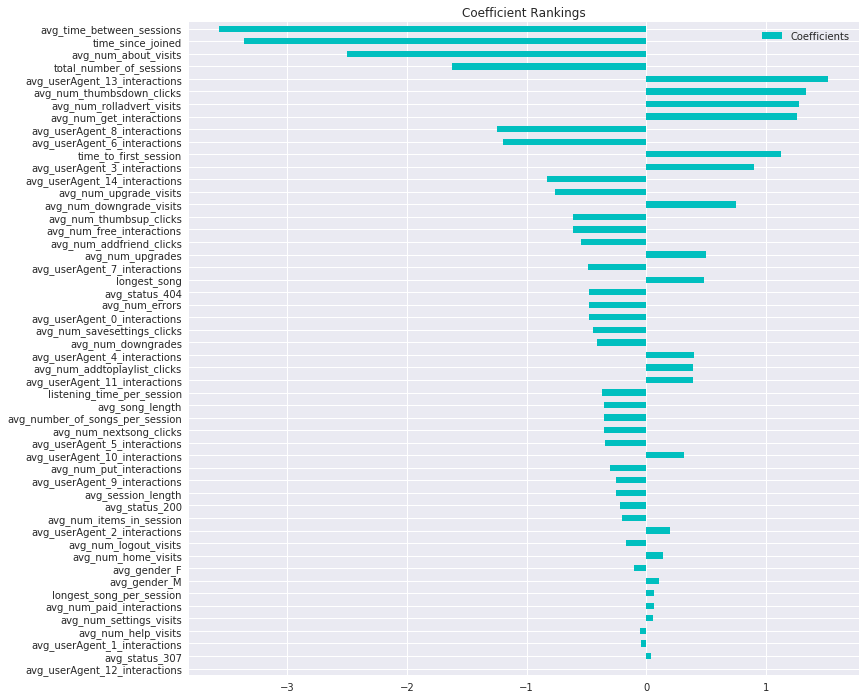

In [42]:
coef = pd.DataFrame(list(bestLRModel.coefficients),
                    index=columns_to_scale,
                    columns=["Coefficients"])
coef['Abs. Value Coefficients'] = np.abs(coef['Coefficients'])
coef['color'] = ['red' if np.sign(x) == -1 else "blue" for x in coef['Coefficients'].values]
print(coef.sort_values(['Abs. Value Coefficients'], ascending=False))
coef.sort_values(['Abs. Value Coefficients'], ascending=True)[["Coefficients", "color"]].plot.barh(title="Coefficient Rankings",
                                                                                       color='color',
                                                                                       label='color')

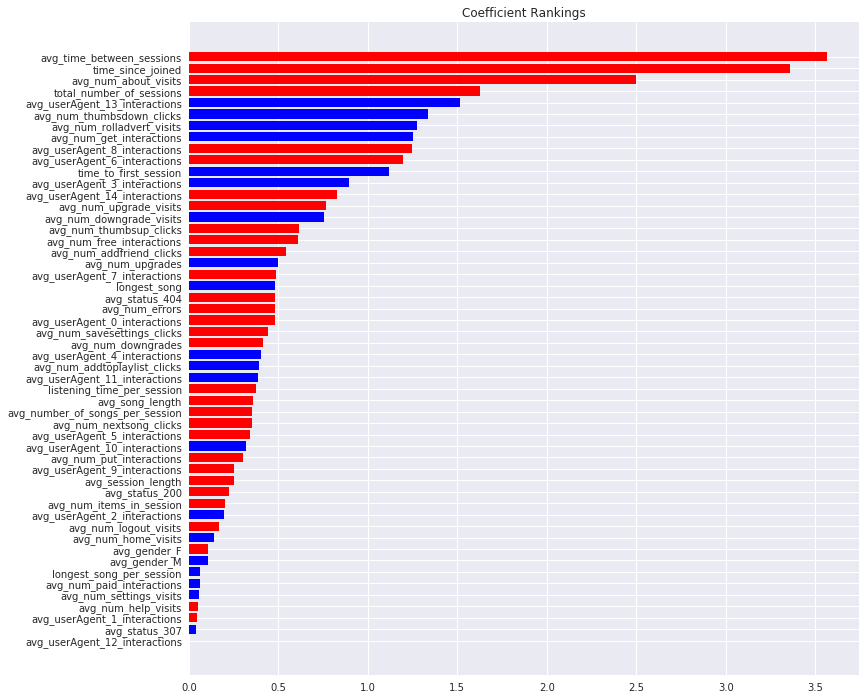

In [43]:
sorted_coef = coef.sort_values(['Abs. Value Coefficients'], ascending=True)
plt.barh(range(len(sorted_coef.index)), sorted_coef['Abs. Value Coefficients'],
         color=sorted_coef['color'])
plt.title('Coefficient Rankings')
plt.yticks(range(len(sorted_coef.index)), sorted_coef.index)
plt.savefig("coef_rank.png")